### Task
Create a 5-year potfolio advise

We will derive our investment strategy as follows:

    1. Starting from 2012 up to 2017 optimize portfolio, using
       denoised optimization methods. 
    2. Select countries by comparing performance on training set.
    3. Invest in the countries with highest sharpe ration on the training set
    4. Research performance of the selected countries in 2017 - 2020
    5. Use 2021 as a validation set
    

We will proceed as follows: firstly we will use convex optimization on denoised 
data


### Convex optimizer

In [1]:
import numpy as np
import pandas as pd
import quantstats as qs
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from pypfopt.risk_models import sample_cov
from pypfopt.expected_returns import mean_historical_return

from robustcov.utils import init_mu_cov
from robustcov.runner import PortfolioCreator
from robustcov.optimizers import ConvexOptimizer
from robustcov.optimizers import NCOOptimizer
import statsmodels.api as sm

qs.extend_pandas()


In [2]:
df = pd.read_csv(Path('..') / 'data' / 'indices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')


# convert price history to expected returns and covariance matrix
mu = mean_historical_return(df).values
cov = sample_cov(df).values


# train/test/oot split
df.loc[df.index < '2017-01-01', 'sample'] = 'train'
df.loc[(df.index > '2017-01-01') & (df.index < '2021-01-01'), 'sample'] = 'test'
df.loc[(df.index > '2021-01-01') & (df.index < df.index.max()), 'sample'] = 'oot'


In [3]:

def calc_stats(returns, weights, country, sample):
    weighted_returns = returns.mul(weights.T.mean(axis=1).values, axis=1)
    portfolio_returns = weighted_returns.sum(axis=1)

    return {
        'sample': sample,
        'country': country,
        'sharpe': portfolio_returns.sharpe(),
        'cumreturn': (1 + portfolio_returns).prod(),
        'win_rate': qs.stats.win_rate(portfolio_returns),
        'avg_win': qs.stats.avg_win(portfolio_returns),
        'consecutive_wins': qs.stats.consecutive_wins(portfolio_returns),
        'consecutive_loss': qs.stats.consecutive_losses(portfolio_returns),
        'max_drawdown': qs.stats.max_drawdown(portfolio_returns),
        'expected_return': qs.stats.expected_return(portfolio_returns),
        '1st_percentile_loss': qs.stats.outlier_loss_ratio(portfolio_returns),
        '99st_percentile_win': qs.stats.outlier_win_ratio(portfolio_returns),
        'profit_factor': qs.stats.profit_factor(portfolio_returns)
    }, portfolio_returns


In [4]:

train = df[df['sample'] == 'train']
test = df[df['sample'] == 'test']
oot = df[df['sample'] == 'oot']

train.pop('sample')
test.pop('sample')
oot.pop('sample')

statistics = []
portf_train_returns = {}
portf_test_returns = {}
portf_oot_returns = {}

df.pop('sample')
names = df.columns.tolist()
countries = np.array([i.split(':')[0] for i in names])
unique_countries, counts = np.unique(countries, return_counts=True)


for n, country in enumerate(unique_countries):

    print(f'{n}/{len(unique_countries)}', end='\r')
    country_mask = countries == country
    stocks = train.loc[:, country_mask]
    buy_and_hold = stocks.pct_change().mean(axis=1)

    mu = mean_historical_return(stocks).values
    cov = sample_cov(stocks).values

    if len(mu) < 4:
        continue

    optimizers = [
        ConvexOptimizer()
    ]

    estimator = PortfolioCreator(
        min_var_portf=False,
        optimizers=optimizers,
        print_every=False,
        bandwidth=1,
        trials=10
    )

    results = estimator.estimate(mu, cov)
    weights = pd.DataFrame(results).T

    train_returns = train.loc[:, country_mask].pct_change()
    test_returns = test.loc[:, country_mask].pct_change()
    oot_returns = oot.loc[:, country_mask].pct_change()

    train_stats, train_returns = calc_stats(train_returns, weights,
                                            country, 'train')
    test_stats, test_returns = calc_stats(test_returns, weights,
                                          country, 'test')

    oot_stats, oot_returns = calc_stats(oot_returns, weights, country, 'oot')

    statistics.append(train_stats)
    statistics.append(test_stats)
    statistics.append(oot_stats)

    portf_train_returns.update({country: train_returns})
    portf_test_returns.update({country: test_returns})
    portf_oot_returns.update({country: oot_returns})

/Users/tomatoparetogmail.com/ds/robust_variance/venv/lib/python3.8/site-packages/quantstats/stats.py:96: RuntimeWarning: invalid value encountered in double_scalars
  return _np.product(1 + returns) ** (1 / len(returns)) - 1
/Users/tomatoparetogmail.com/ds/robust_variance/venv/lib/python3.8/site-packages/quantstats/stats.py:96: RuntimeWarning: invalid value encountered in double_scalars
  return _np.product(1 + returns) ** (1 / len(returns)) - 1


In [5]:

stats = pd.DataFrame(statistics)
portf_train = pd.DataFrame(portf_train_returns)
portf_test = pd.DataFrame(portf_test_returns)
portf_oot = pd.DataFrame(portf_oot_returns)

### Step 3: Invest in the countries with highest sharpe ration on the training set

Now select 5 countries by highest value of Sharpe ration to invest:

In [6]:
stats[stats['sample'] == 'train'].sort_values('sharpe', ascending=False).head()

,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
108,train,World,6.926051,1.027013,0.677147,0.000045,20,8,-0.005124,0.000020,2.799849,2.785485,3.031372
93,train,Sweden,4.588226,1.196619,0.627078,0.000431,17,15,-0.006788,0.000138,3.030095,3.026716,2.113489
63,train,Mauritius,3.900947,4.464242,0.581994,0.003652,11,10,-0.048002,0.001147,3.528740,4.914800,2.334481
51,train,Ireland,3.523038,2.181800,0.619632,0.002168,16,6,-0.032996,0.000598,3.349348,3.567914,1.812072
6,train,Belgium,3.416821,1.397077,0.595991,0.001017,12,9,-0.014761,0.000256,3.173878,3.079234,1.743888


In [7]:
def plot_cum_returns(train, test, oot, country):

    plt.suptitle('Cumulated returns IN and OUT of sample')
    f, ax = plt.subplots(figsize=(16, 5), ncols=3)

    ax[0].set_title('Cumulated returns in-sample')
    ax[1].set_title('Cumulated returns out-of-sample')
    ax[2].set_title('Cumulated returns out-of-time')
    
    ax[0].set_ylabel('Log cumreturn')
    ax[1].set_ylabel('Log cumreturn')
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    # ax[2].set_yscale('log')
    
    (1 + train[country]).cumprod().plot(ax=ax[0])
    (1 + test[country]).cumprod().plot(ax=ax[1])
    (1 + oot[country]).cumprod().plot(ax=ax[2])
    
    plt.tight_layout()

If we invested with weights, obtained during in-sample optimization procedure 
in 5 stated above countries, we would obatin following values in each of the 
samples:

<Figure size 1000x600 with 0 Axes>

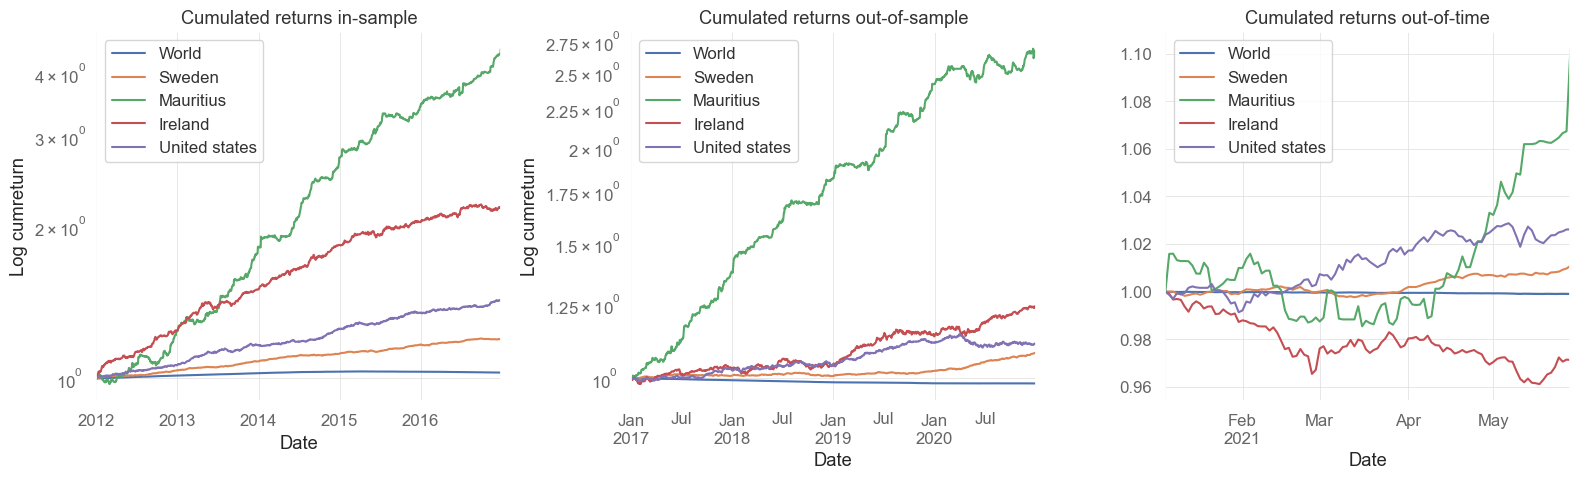

In [8]:
plot_cum_returns(portf_train, portf_test, portf_oot, ['World', 'Sweden', 'Mauritius', 'Ireland', 'United states'])

In [9]:
selected_countries = ['World', 'Sweden', 'Mauritius', 'Ireland', 'United states']

# out positions
positions = stats[(stats['sample'] == 'oot') & (stats['country'].isin(selected_countries))]
positions

,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
53,oot,Ireland,-1.982879,0.971333,0.476190,0.001455,5,5,-0.038767,-0.000274,2.138032,2.906134,0.716120
65,oot,Mauritius,2.801511,1.102030,0.552083,0.003990,5,5,-0.030002,0.000917,3.562942,4.679695,1.874437
95,oot,Sweden,3.144187,1.010826,0.617647,0.000433,10,3,-0.004500,0.000102,2.817230,2.631667,1.652971
107,oot,United states,2.043576,1.026164,0.571429,0.001537,7,4,-0.011801,0.000244,2.831183,2.982589,1.392986
110,oot,World,-3.926762,0.999041,0.371429,0.000028,4,8,-0.000959,-0.000009,2.695920,3.511399,0.528736


In [10]:
# our mean cumulated return for 6 months
positions['cumreturn'].mean()

1.0218789449365933

## Portfolio from all of the countries using denoised convex optimization

What if we instead tried to create portfolio from all of the countries:

In [11]:
df = pd.read_csv(Path('..') / 'data' / 'indices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')


# train/test/oot split
df.loc[df.index < '2017-01-01', 'sample'] = 'train'
df.loc[(df.index > '2017-01-01') & (df.index < '2021-01-01'), 'sample'] = 'test'
df.loc[(df.index > '2021-01-01') & (df.index < df.index.max()), 'sample'] = 'oot'


In [12]:

train = df[df['sample'] == 'train']
test = df[df['sample'] == 'test']
oot = df[df['sample'] == 'oot']

train.pop('sample')
test.pop('sample')
oot.pop('sample')

statistics = []
portf_train_returns = {}
portf_test_returns = {}
portf_oot_returns = {}

df.pop('sample')


mu = mean_historical_return(train).values
cov = sample_cov(train).values

optimizers = [
    ConvexOptimizer()
]

estimator = PortfolioCreator(
    min_var_portf=False,
    optimizers=optimizers,
    print_every=1,
    bandwidth=1,
    trials=10
)

results = estimator.estimate(mu, cov)
weights = pd.DataFrame(results).T

train_returns = train.loc[:, country_mask].pct_change()
test_returns = test.loc[:, country_mask].pct_change()
oot_returns = oot.loc[:, country_mask].pct_change()


[0/10] done
[1/10] done
[2/10] done
[3/10] done
[4/10] done
[5/10] done
[6/10] done
[7/10] done
[8/10] done
[9/10] done


In [19]:

def calc_stats(returns, weights, sample):
    weighted_returns = returns.mul(weights.T.mean(axis=1).values, axis=1)
    portfolio_returns = weighted_returns.sum(axis=1)

    return {
        'sample': sample,
        'sharpe': portfolio_returns.sharpe(),
        'cumreturn': (1 + portfolio_returns).prod(),
        'win_rate': qs.stats.win_rate(portfolio_returns),
        'avg_win': qs.stats.avg_win(portfolio_returns),
        'consecutive_wins': qs.stats.consecutive_wins(portfolio_returns),
        'consecutive_loss': qs.stats.consecutive_losses(portfolio_returns),
        'max_drawdown': qs.stats.max_drawdown(portfolio_returns),
        'expected_return': qs.stats.expected_return(portfolio_returns),
        '1st_percentile_loss': qs.stats.outlier_loss_ratio(portfolio_returns),
        '99st_percentile_win': qs.stats.outlier_win_ratio(portfolio_returns),
        'profit_factor': qs.stats.profit_factor(portfolio_returns)
    }, portfolio_returns


train_stats, train_portf = calc_stats(train.pct_change().fillna(0), weights, 'train')
test_stats, test_portf = calc_stats(test.pct_change().fillna(0), weights, 'test')
oot_stats, oot_portf = calc_stats(oot.pct_change().fillna(0), weights, 'oot')


<Figure size 1000x600 with 0 Axes>

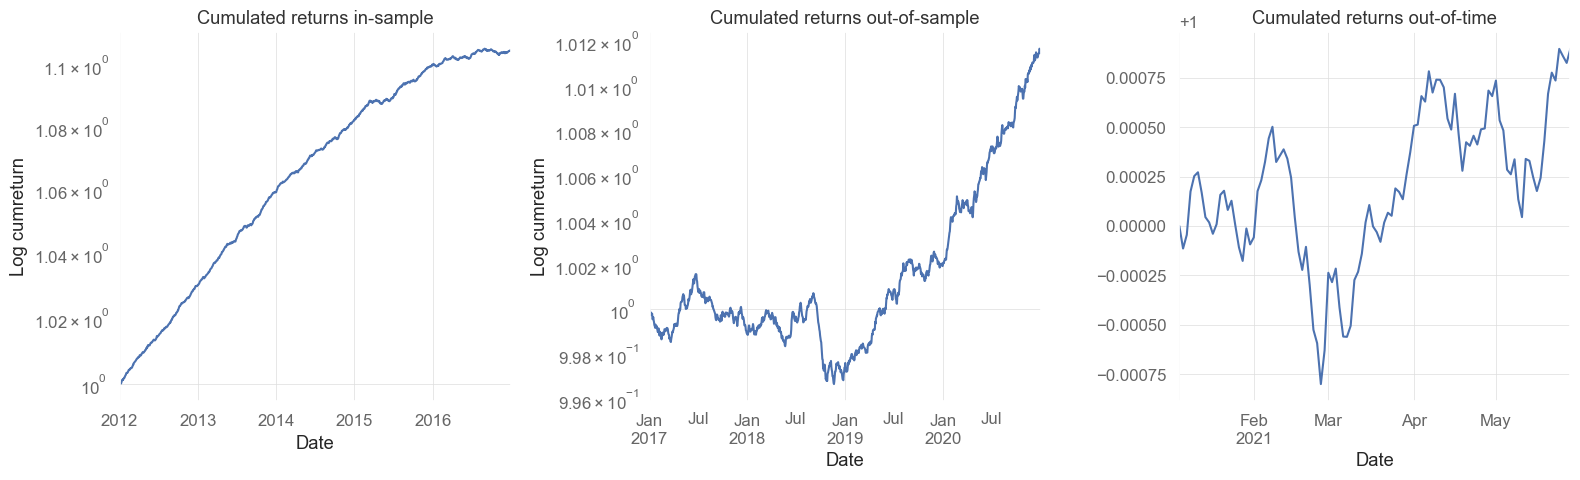

In [30]:
plt.suptitle('Cumulated returns IN and OUT of sample')
f, ax = plt.subplots(figsize=(16, 5), ncols=3)

ax[0].set_title('Cumulated returns in-sample')
ax[1].set_title('Cumulated returns out-of-sample')
ax[2].set_title('Cumulated returns out-of-time')

ax[0].set_ylabel('Log cumreturn')
ax[1].set_ylabel('Log cumreturn')
ax[0].set_yscale('log')
ax[1].set_yscale('log')

(1 + train_portf).cumprod().plot(ax=ax[0])
(1 + test_portf).cumprod().plot(ax=ax[1])
(1 + oot_portf).cumprod().plot(ax=ax[2])

plt.tight_layout()

In [32]:
test_stats

{'sample': 'test',
 'sharpe': 1.4785536759099172,
 'cumreturn': 1.0114762821168413,
 'win_rate': 0.5369127516778524,
 'avg_win': 9.72800735083649e-05,
 'consecutive_wins': 10,
 'consecutive_loss': 19,
 'max_drawdown': -0.00488416675347314,
 'expected_return': 1.0930068470527132e-05,
 '1st_percentile_loss': 2.7231938382671603,
 '99st_percentile_win': 3.216476315537367,
 'profit_factor': 1.265177371779722}

In [33]:
oot_stats

{'sample': 'oot',
 'sharpe': 1.0711816728893435,
 'cumreturn': 1.000897421244473,
 'win_rate': 0.49523809523809526,
 'avg_win': 0.00011236736379925013,
 'consecutive_wins': 6,
 'consecutive_loss': 5,
 'max_drawdown': -0.0013012675778076854,
 'expected_return': 8.462477342208174e-06,
 '1st_percentile_loss': 2.216829608611784,
 '99st_percentile_win': 2.6457508228958537,
 'profit_factor': 1.1815579086002235}

### Rebalance each month

In [ ]:
# for i, train_ in train.resample('1m'):
#     print(idx)